In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/home/data/simon/processed/test_areas/houston_new/flood"
figure_folder = "/home/data/simon/result/HSBA_houston"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];


In [3]:
threshold_indx = 3

3

## VV

In [4]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

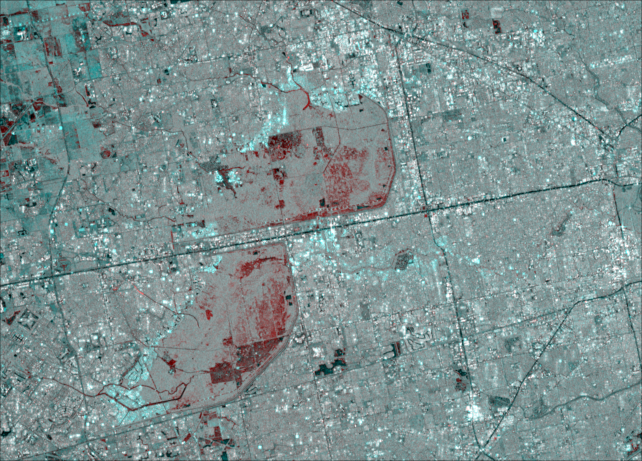

In [5]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [6]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [7]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


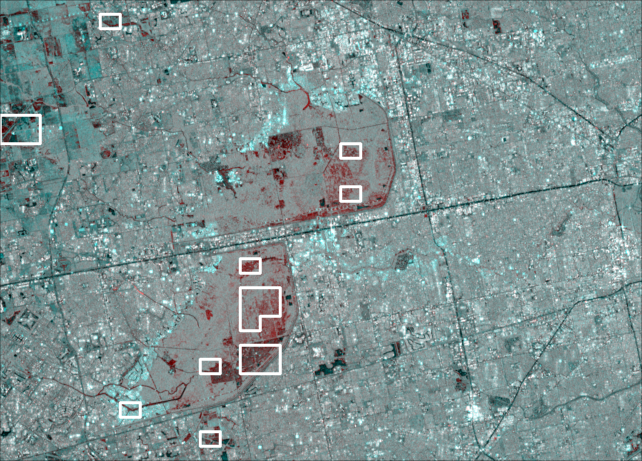

In [8]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VV_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [60]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [10]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-12.55, -1.0], f_i: 0.0007546828081812434
dfdx: [-0.0022832170326023437, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 2
x_i: [10.282170326023437, -1.0], f_i: 0.00016390557778762024
dfdx: [0.0, 2.8857757050209378e-5]
Step x, step_idx:1,  no_step: -2

Iterration : 3
x_i: [10.282170326023437, -1.002885775705021], f_i: 0.0001638824357756964
dfdx: [0.0, -5.4992007562638885e-6]
Step x, step_idx:3,  no_step: -2

Iterration : 4
x_i: [10.282170326023437, -0.947893768142382], f_i: 0.00015960818006785147
dfdx: [0.0, -0.00010620363097220721]
Step x, step_idx:2,  no_step: -2

Iterration : 5
x_i: [10.282170326023437, -0.8416901371701748], f_i: 0.00015144003595643152
dfdx: [0.0, -4.8285365220240345e-5]
Step x, step_idx:2,  no_step: -2

Iterration : 6
x_i: [10.282170326023437, -0.7934047719499345], f_i: 0.0001506399292879743
dfdx: [0.0, 1.3660089732070378e-5]
No change, Decrease delta, no_step: -1

Iterration : 7
x_i: [10.282170326023437, -0.7934047719499345], f_i: 0.00015

In [11]:
thresholds3, f3

([10.283921607442295, -0.6731731102653867], 0.0001468324885827938)

In [12]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-0.08051757812499394, -0.6618408203124998], 0.0001467643669580307)

In [13]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-11.25064651293976, 1.9344084362045546], 0.0002254738844279294)

In [14]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [15]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VV.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [16]:
test_sigma = collect(LinRange(y_seed,-8,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [17]:
minimum(loss),maximum(loss)

(0.00014753108795445975, 0.0019147720443068784)

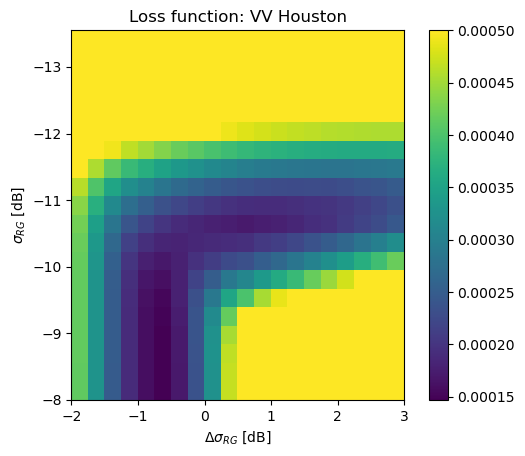

In [21]:
file_path = joinpath(figure_folder,"VV_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.0005,vmax=0.000147
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VV Houston")
PyPlot.savefig(file_path)

In [70]:
#y_seed =-14
rg_thresholds = [-11.0,-1]
seed_mask = flood_band .< y_seed;
y_seed

-13.55

In [71]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [72]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

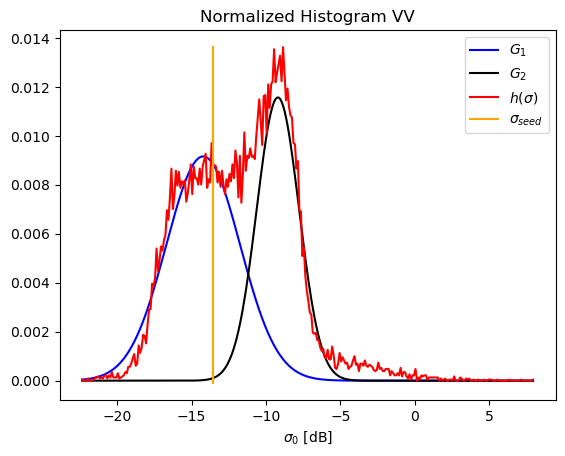

In [73]:
file_path = joinpath(figure_folder,"VV_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

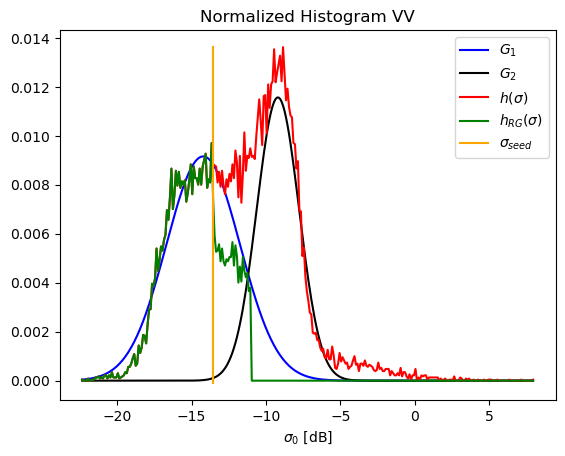

In [74]:
file_path = joinpath(figure_folder,"VV_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

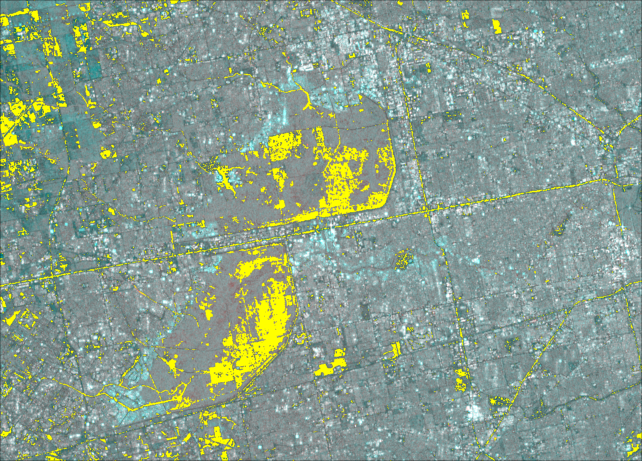

In [75]:
img_save = add_mask(imgVV,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VV_flood_noref_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [76]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

Max Iter reached:  region_growing()


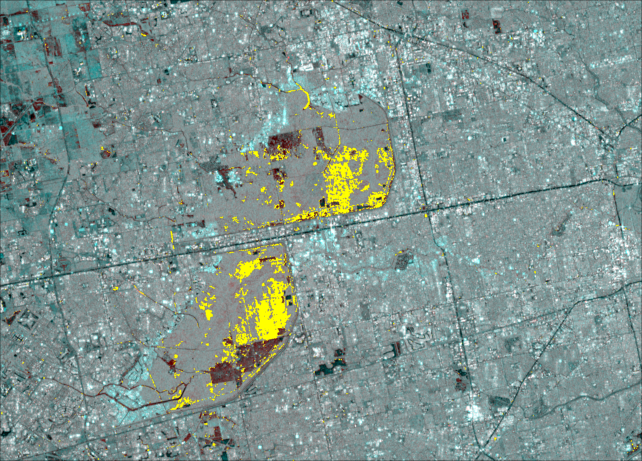

In [77]:
img_save = add_mask(imgVV,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VV_flood_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [78]:
file_path = joinpath(data_folder,"VVhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)

## VH

In [79]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

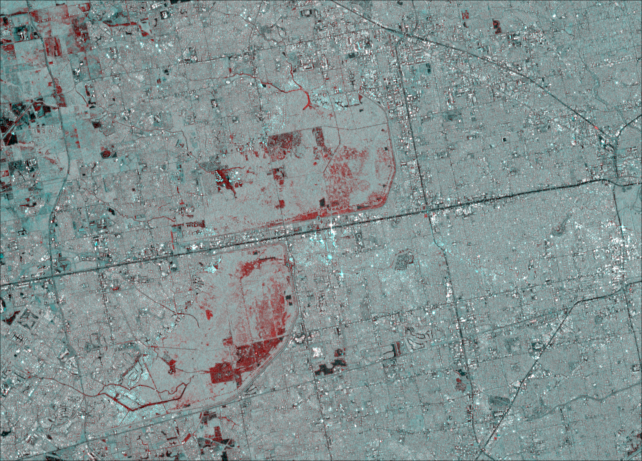

In [80]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [81]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [82]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


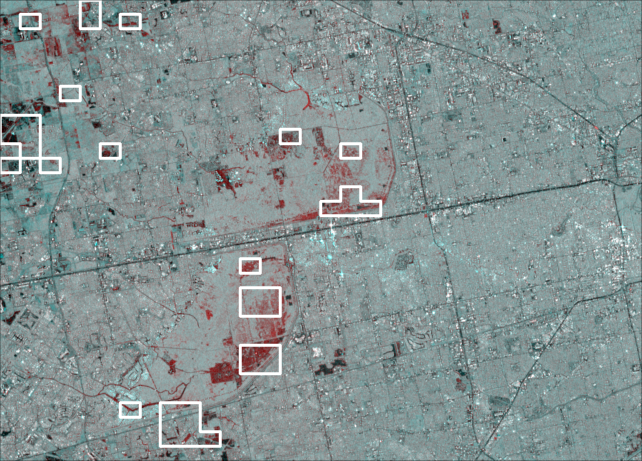

In [83]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VH_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [84]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [35]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-19.525, -1.0], f_i: 0.0003867234770331879
dfdx: [-0.00044436908532290316, 0.0]
Step x, step_idx:4,  no_step: -2

Iterration : 2
x_i: [24.91190853229032, -1.0], f_i: 7.065992989515306e-5
dfdx: [0.0, -4.600152256255213e-5]
Step x, step_idx:3,  no_step: -2

Iterration : 3
x_i: [24.91190853229032, -0.5399847743744787], f_i: 4.8767071935787435e-5
dfdx: [0.0, -1.9367011442527674e-5]
Max Iter reached:  region_growing()
Step x, step_idx:3,  no_step: -2

Iterration : 4
x_i: [24.91190853229032, -0.34631465994920196], f_i: 4.685764932183971e-5
dfdx: [0.0, 7.760714692019425e-6]
Step x, step_idx:3,  no_step: -2

Iterration : 5
x_i: [24.91190853229032, -0.4239218068693962], f_i: 4.678791813304375e-5
dfdx: [0.0, -7.575381718482479e-6]
Max Iter reached:  region_growing()
Step x, step_idx:2,  no_step: -2
Max Iter reached:  region_growing()

Iterration : 6
x_i: [24.91190853229032, -0.4163464251509137], f_i: 4.670687750541253e-5
dfdx: [0.0, 2.512699250778695e-5]
No change, Decrease

In [36]:
thresholds3, f3

([24.91190853229032, -0.4163464251509137], 4.670687750541253e-5)

In [37]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([4.920974731445314, -0.39778442382812473], 4.664832365859731e-5)

In [38]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-18.024572565851077, 0.24798208876474134], 0.00016502292295268592)

In [39]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [40]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VH.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [61]:
test_sigma = collect(LinRange(y_seed,-14,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [62]:
minimum(loss),maximum(loss)

(4.7153428925164945e-5, 0.0013562307327770456)

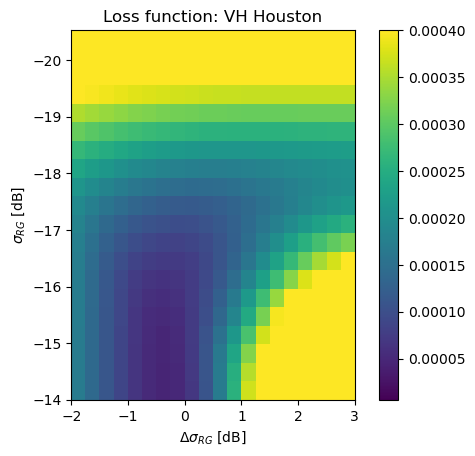

In [63]:
file_path = joinpath(figure_folder,"VH_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.00000630,vmax= 0.0004
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VH Houston")
PyPlot.savefig(file_path)

In [85]:
#y_seed =-15
rg_thresholds = [-18,-1]
seed_mask = flood_band .< y_seed;
y_seed

-20.525

In [86]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [87]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

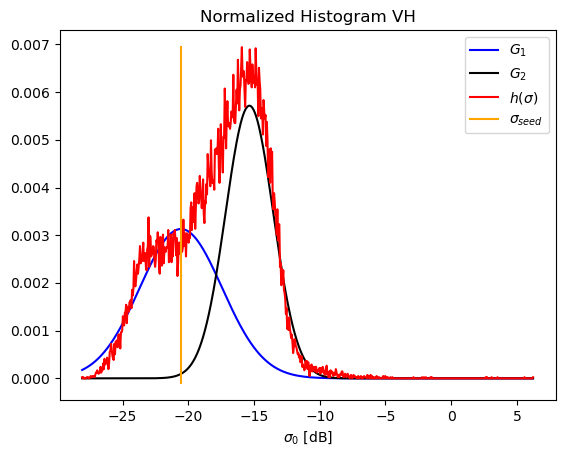

In [88]:
file_path = joinpath(figure_folder,"VH_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

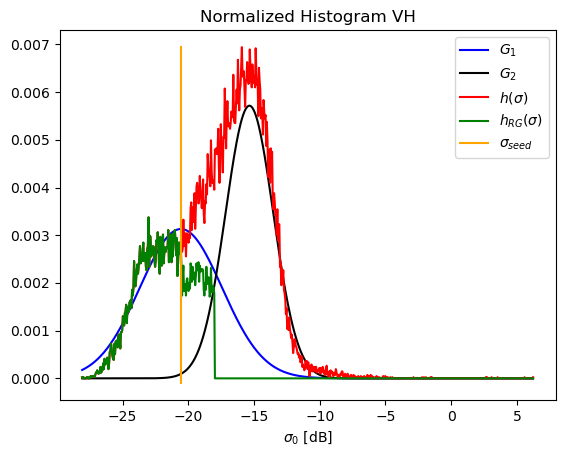

In [89]:
file_path = joinpath(figure_folder,"VH_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

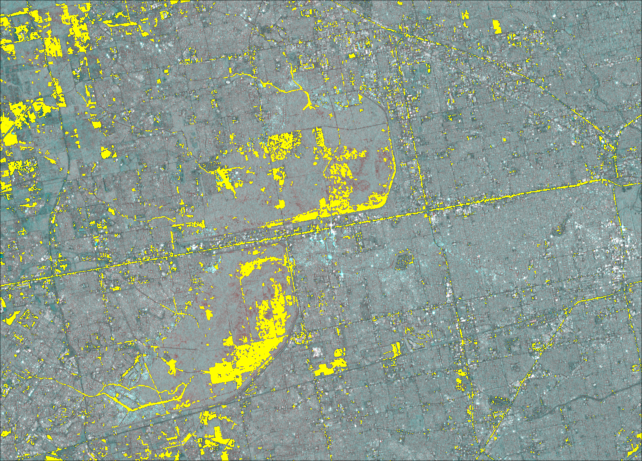

In [90]:
img_save = add_mask(imgVH,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VH_flood_noref_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [91]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

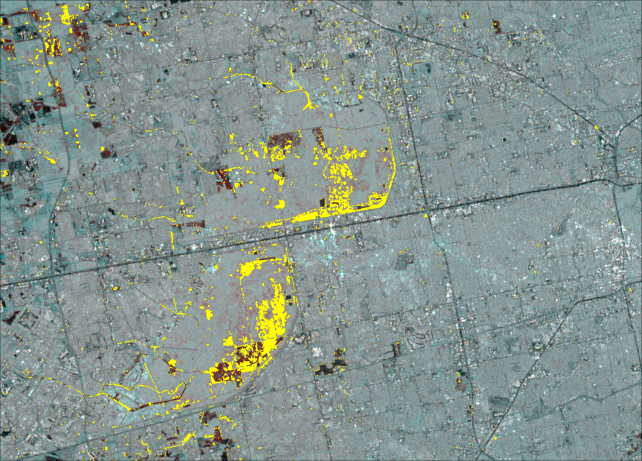

In [92]:
img_save = add_mask(imgVH,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VH_flood_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [ ]:
file_path = joinpath(data_folder,"VHhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)